Prediction: Pixelated
Input tensor size: torch.Size([1, 3, 256, 256])
Output tensor size: torch.Size([3, 1024, 1024])


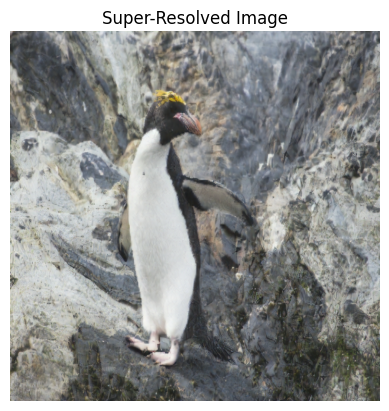

Resolved


In [4]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import joblib
import cv2
import numpy as np
from skimage.feature import hog
from scipy.fftpack import dct
from concurrent.futures import ThreadPoolExecutor

# Specify the path to the saved model
model_path = os.path.join(r'C:\Users\KIIT\Desktop\Projects\model', 'pixelation_model.pkl')

def extract_patch_features(patch):
    patch_float = patch.astype(np.float32) / 255.0

    # Edge detection
    edges = cv2.Canny(patch, 100, 200)
    edge_feature = np.sum(edges) / (patch.shape[0] * patch.shape[1])

    # Block-like patterns using DCT
    dct_features = dct(dct(patch_float, axis=0, norm='ortho'), axis=1, norm='ortho')
    dct_features = dct_features[:8, :8].flatten()

    # Histogram of pixel intensities
    hist = cv2.calcHist([patch], [0], None, [32], [0, 256])
    hist_features = hist.flatten() / np.sum(hist)

    # HOG for texture
    hog_features = hog(patch, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)

    # Fast Fourier Transform for frequency analysis
    f_transform = np.fft.fft2(patch_float)
    f_transform = np.abs(np.fft.fftshift(f_transform))
    f_features = f_transform[:8, :8].flatten()

    return np.concatenate([
        [edge_feature],
        dct_features,
        hist_features,
        hog_features,
        f_features
    ])

def process_patch(img, y, x, patch_size):
    patch = img[y:y+patch_size, x:x+patch_size]
    return extract_patch_features(patch)

def extract_image_features(image_path, patch_size=128, stride=32):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None

    patch_features = []
    patch_coords = [(y, x) for y in range(0, img.shape[0] - patch_size + 1, stride)
                            for x in range(0, img.shape[1] - patch_size + 1, stride)]

    with ThreadPoolExecutor() as executor:
        patch_features = list(executor.map(lambda coords: process_patch(img, coords[0], coords[1], patch_size), patch_coords))

    if not patch_features:
        return None

    patch_features = np.array(patch_features)

    # Aggregate patch features
    mean_features = np.mean(patch_features, axis=0)
    max_features = np.max(patch_features, axis=0)
    std_features = np.std(patch_features, axis=0)

    # High pixelation ratio (using edge and DCT features)
    edge_scores = patch_features[:, 0]
    dct_scores = np.sum(patch_features[:, 1:65], axis=1)
    high_edge_ratio = np.mean(edge_scores > np.median(edge_scores) * 1.5)
    high_dct_ratio = np.mean(dct_scores > np.median(dct_scores) * 1.5)

    return np.concatenate([
        mean_features, max_features, std_features,
        [high_edge_ratio, high_dct_ratio]
    ])

# Load the model from the file
loaded_model = joblib.load(model_path)


#################################################################

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

class Generator(nn.Module):
    def __init__(self, num_residual_blocks):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.prelu = nn.PReLU()

        self.residual_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residual_blocks)])

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.upscale1 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle1 = nn.PixelShuffle(2)
        self.prelu1 = nn.PReLU()

        self.upscale2 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle2 = nn.PixelShuffle(2)
        self.prelu2 = nn.PReLU()

        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = self.prelu(self.conv1(x))
        residual = x
        x = self.residual_blocks(x)
        x = self.bn2(self.conv2(x))
        x = x + residual
        x = self.prelu1(self.pixel_shuffle1(self.upscale1(x)))
        x = self.prelu2(self.pixel_shuffle2(self.upscale2(x)))
        x = self.conv3(x)
        return x

# Load the trained generator model
generator = Generator(num_residual_blocks=16)  # Make sure to specify the correct number of residual blocks
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)

# Map the model to the CPU if CUDA is not available
if not torch.cuda.is_available():
    generator.load_state_dict(torch.load(r'C:\Users\KIIT\Desktop\Projects\model\generator.pth', map_location=torch.device('cpu')))
else:
    generator.load_state_dict(torch.load(r'C:\Users\KIIT\Desktop\Projects\model\generator.pth'))

generator.eval()

# Define the inference function
def super_resolve_image(lr_image_path, output_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256), antialias=True),  # Change this to 64x64 for 4x upscaling
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    lr_image = Image.open(lr_image_path).convert('RGB')
    lr_image_tensor = transform(lr_image).unsqueeze(0).to(device)
    
    print(f"Input tensor size: {lr_image_tensor.size()}")

    with torch.no_grad():
        sr_image_tensor = generator(lr_image_tensor).cpu().squeeze(0)
    
    print(f"Output tensor size: {sr_image_tensor.size()}")
    
    sr_image_tensor = sr_image_tensor * 0.5 + 0.5  # Denormalize the image
    sr_image_np = sr_image_tensor.permute(1, 2, 0).numpy()
    
    # Ensure the numpy array values are within the [0, 1] range
    sr_image_np = (sr_image_np - sr_image_np.min()) / (sr_image_np.max() - sr_image_np.min())
    
    # Save the image using matplotlib
    plt.imsave(output_path, sr_image_np)
    
    # Display the image using matplotlib
    plt.imshow(sr_image_np)
    plt.title("Super-Resolved Image")
    plt.axis('off')
    plt.show()

# Usage
def usage(image_path):
    features = extract_image_features(image_path)
    features = features.reshape(1, -1)

    # Make predictions with the loaded model
    prediction = loaded_model.predict(features)
    print(f"Prediction: {'Pixelated' if prediction == 1 else 'Not Pixelated'}")

    # Update this to your low-resolution image path
    output_path = r'C:\Users\KIIT\Desktop\Projects\model\resolved_image.jpg'  # Path where the super-resolved image will be saved
    if (prediction == 1):
        super_resolve_image(image_path, output_path)
        print("Resolved")
    else :
        print("No need to resolve")

usage(image_path = r'C:\Users\KIIT\Desktop\Projects\model\unresolved_image.jpg')